# Задание

1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, выберите оптимальное значение.

2. Примените нормализацию данных. Исследуйте скорость сходимости.

3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.

4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
https://pytorch.org/docs/stable/optim.html

6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

# Решение

In [1]:
import torch

device = torch.device("cpu")

Получение датафрейма

In [2]:
import pandas as pd

def get_df(path = 'weatherAUS.csv'):
    df = pd.read_csv(path).dropna()
    df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
    df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)
    return df

Поскольку классы несбалансированы, то преобразуем в тензор

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def convert_X_to_tensor(X, is_scaled):
    return torch.from_numpy(X.to_numpy() if not is_scaled else X).float()

def convert_y_to_tensor(y, is_scaled):
    return torch.squeeze(torch.from_numpy(y.to_numpy() if not is_scaled else y).float())

def get_X_y_tensor(df, is_scaled = False):
    X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
    y = df[['RainTomorrow']]

    if is_scaled:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        y = scaler.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = convert_X_to_tensor(X_train, is_scaled).to(device)
    y_train = convert_y_to_tensor(y_train, is_scaled).to(device)
    X_test = convert_X_to_tensor(X_test, is_scaled).to(device)
    y_test = convert_y_to_tensor(y_test, is_scaled).to(device)

    return X_train, X_test, y_train, y_test

Исходная модель NN

In [4]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

Функция для подсчета точности

In [5]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

Функция для подсчета потерь и точности на разных параметрах

In [6]:
from torch import optim

def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion = nn.BCELoss().to(device)):
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:

            y_test_pred = net(X_test)
            y_test_pred = torch.squeeze(y_test_pred)

            test_loss = criterion(y_test_pred, y_test)
            test_acc = calculate_accuracy(y_test, y_test_pred)

            print(f'''epoch {epoch}
                        Test  set - loss: {test_loss}, accuracy: {test_acc}
                    ''')
            
            epoch_losses.append(test_loss)
            epoch_accuracies.append(test_acc)

    return epoch_losses, epoch_accuracies

In [7]:
def calc_by_learning_rates(X_train, X_test, y_train, y_test, learning_rates, num_epochs):
    results = {}

    for lr in learning_rates:
        print(f'learning_rate={lr}')
        
        net = Net(4).to(device)
        optimizer = optim.Adam(net.parameters(), lr=lr)

        epoch_losses, epoch_accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer)
        
        results[lr] = {
            'losses': epoch_losses,
            'accuracies': epoch_accuracies,
        }

    return results

def calc_by_architectures(X_train, X_test, y_train, y_test, architectures, optim_learning_rate, num_epochs):
    results = {}

    for architecture in architectures:
        print(f'Testing architecture: {architecture}')
        
        net = Net(4, architecture).to(device)
        optimizer = optim.Adam(net.parameters(), lr=optim_learning_rate)

        epoch_losses, epoch_accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer)
        
        results[str(architecture)] = {
            'losses': epoch_losses,
            'accuracies': epoch_accuracies,
        }

    return results

def calc_by_activation_functions(X_train, X_test, y_train, y_test, activation_functions, optim_learning_rate, num_epochs):
    results = {}

    for activation_fn in activation_functions:
        print(f'Activation Function: {activation_fn.__name__}')
        
        net = Net(4, activation_fn).to(device)
        optimizer = optim.Adam(net.parameters(), lr=optim_learning_rate)

        epoch_losses, epoch_accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer)
        
        results[activation_fn.__name__] = {
            'losses': epoch_losses,
            'accuracies': epoch_accuracies,
        }

    return results

def calc_by_optimizers(X_train, X_test, y_train, y_test, optimizers, optim_learning_rate, optim_fn, num_epochs):
    results = {}

    for optimizer_name, optimizer_class in optimizers:
        print(f'Optimizer: {optimizer_name}')
        
        net = Net(4, optim_fn).to(device)
        optimizer = optimizer_class(net.parameters(), lr=optim_learning_rate)

        epoch_losses, epoch_accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer)
        
        results[optimizer_name] = {
            'losses': epoch_losses,
            'accuracies': epoch_accuracies,
        }

    return results

def initialize_weights(model, init_type):
    if init_type == 'random':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.zeros_(m.bias)
    elif init_type == 'xavier':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    elif init_type == 'he':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.zeros_(m.bias)
    elif init_type == 'zero':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight)
                nn.init.zeros_(m.bias)
    return model

def calc_by_weight_initialization(X_train, X_test, y_train, y_test, init_types, optim_learning_rate, optim_fn, num_epochs):
    results = {}

    for init_type in init_types:
        print(f'Weight Initialization: {init_type}')
        
        net = Net(4, optim_fn).to(device)
        net = initialize_weights(net, init_type)
        optimizer = optim.Adam(net.parameters(), lr=optim_learning_rate)

        epoch_losses, epoch_accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer)
        
        results[init_type] = {
            'losses': epoch_losses,
            'accuracies': epoch_accuracies,
        }

    return results

In [8]:
def calc_loss(X_train, X_test, y_train, y_test, 
              num_epochs = 2000, learning_rates = None, architectures = None, 
              activation_functions = None, optimizers = None, init_types = None,
              optim_lr = None, optim_fn = None):
    
    if learning_rates != None:
        results = calc_by_learning_rates(X_train, X_test, y_train, y_test, learning_rates, num_epochs)
    
    elif architectures != None:
        results = calc_by_architectures(X_train, X_test, y_train, y_test, architectures, optim_lr, num_epochs)

    elif activation_functions != None:
        results = calc_by_activation_functions(X_train, X_test, y_train, y_test, activation_functions, optim_lr, num_epochs)
    
    elif optimizers != None:
        results = calc_by_optimizers(X_train, X_test, y_train, y_test, optimizers, optim_lr, optim_fn, num_epochs)

    else:
        results = calc_by_weight_initialization(X_train, X_test, y_train, y_test, init_types, optim_lr, optim_fn, num_epochs)

    return results

Функция для отрисовки потерь и точности

In [9]:
import matplotlib.pyplot as plt

def visualize_results(results):
    plt.figure(figsize=(6, 4))

    for param, metrics in results.items():
        losses = [loss.detach().cpu().numpy() for loss in metrics["losses"]]
        accuracies = [acc.detach().cpu().numpy() for acc in metrics["accuracies"]]

        epochs = range(0, len(losses) * 100, 100)
        
        fig, ax1 = plt.subplots(figsize=(6, 4)) 

        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14, color='tab:red')
        ax1.plot(epochs, losses, label=f'Loss ({param})', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')
        ax1.grid(True, linestyle="--", alpha=0.7)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', fontsize=14, color='tab:blue')
        ax2.plot(epochs, accuracies, label=f'Accuracy ({param})', color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        fig.suptitle(f"Convergence for {param}", fontsize=16)
        fig.tight_layout()
        plt.legend(loc='upper left', fontsize=12)
        plt.show()

### 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, выберите оптимальное значение.

In [10]:
df = get_df()

X_train, X_test, y_train, y_test = get_X_y_tensor(df)

C:\Users\Юлия\AppData\Local\Temp\ipykernel_12932\4245490189.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\Юлия\AppData\Local\Temp\ipykernel_12932\4245490189.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday']

In [11]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

In [12]:
results = calc_loss(X_train, X_test, y_train, y_test, learning_rates=learning_rates)

learning_rate=0.0001
epoch 0
                        Test  set - loss: 77.84844970703125, accuracy: 0.2201347053050995
                    
epoch 100
                        Test  set - loss: 5.384857177734375, accuracy: 0.1912442445755005
                    
epoch 200
                        Test  set - loss: 1.6986206769943237, accuracy: 0.599078357219696
                    
epoch 300
                        Test  set - loss: 1.6507242918014526, accuracy: 0.6019142270088196
                    
epoch 400
                        Test  set - loss: 1.6010756492614746, accuracy: 0.6043069958686829
                    
epoch 500
                        Test  set - loss: 1.5506610870361328, accuracy: 0.6086494326591492
                    
epoch 600
                        Test  set - loss: 1.5002477169036865, accuracy: 0.6099787354469299
                    
epoch 700
                        Test  set - loss: 1.4503679275512695, accuracy: 0.6104218363761902
                    
epoch 80

<Figure size 600x400 with 0 Axes>

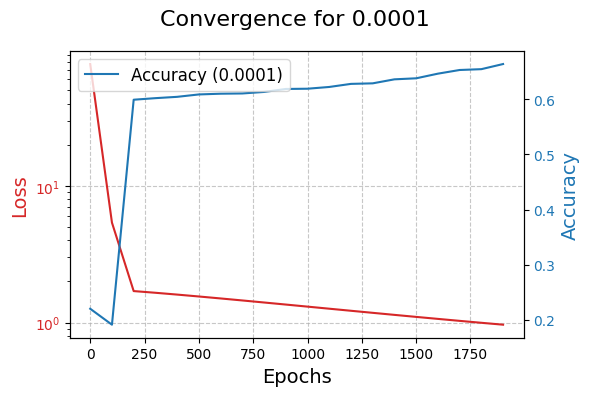

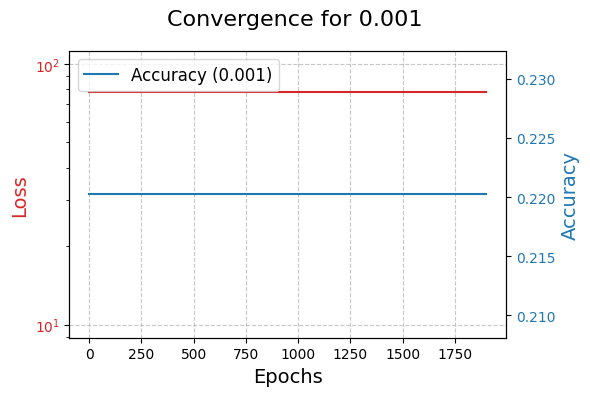

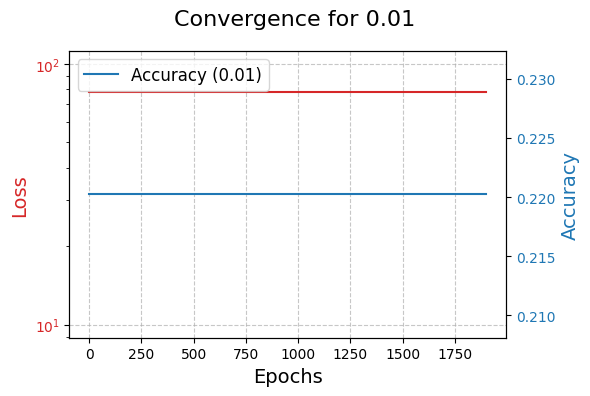

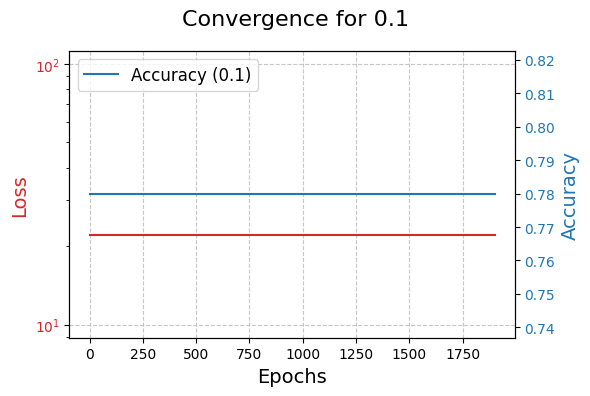

In [13]:
visualize_results(results)

In [14]:
optim_learning_rate = 0.0001

### 2. Примените нормализацию данных. Исследуйте скорость сходимости.

In [15]:
X_train, X_test, y_train, y_test = get_X_y_tensor(df, is_scaled=True)

In [16]:
results = calc_loss(X_train, X_test, y_train, y_test, learning_rates=learning_rates)

learning_rate=0.0001
epoch 0
                        Test  set - loss: 0.7499710917472839, accuracy: 0.2202233225107193
                    
epoch 100
                        Test  set - loss: 0.7365508675575256, accuracy: 0.2202233225107193
                    
epoch 200
                        Test  set - loss: 0.7232850193977356, accuracy: 0.2202233225107193
                    
epoch 300
                        Test  set - loss: 0.7100259065628052, accuracy: 0.22589507699012756
                    
epoch 400
                        Test  set - loss: 0.6959279775619507, accuracy: 0.44186457991600037
                    
epoch 500
                        Test  set - loss: 0.6808070540428162, accuracy: 0.7278447151184082
                    
epoch 600
                        Test  set - loss: 0.6639630794525146, accuracy: 0.7798653244972229
                    
epoch 700
                        Test  set - loss: 0.6469363570213318, accuracy: 0.7797766923904419
                    
epo

<Figure size 600x400 with 0 Axes>

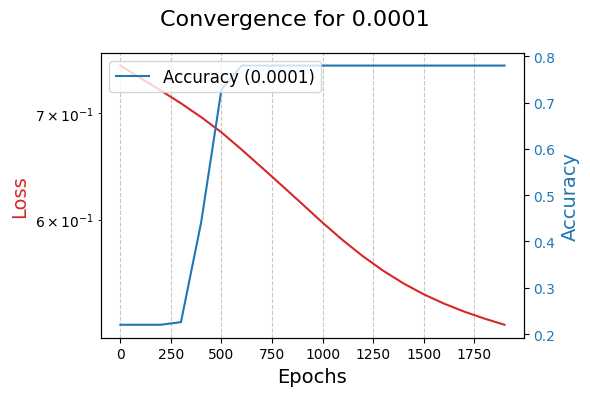

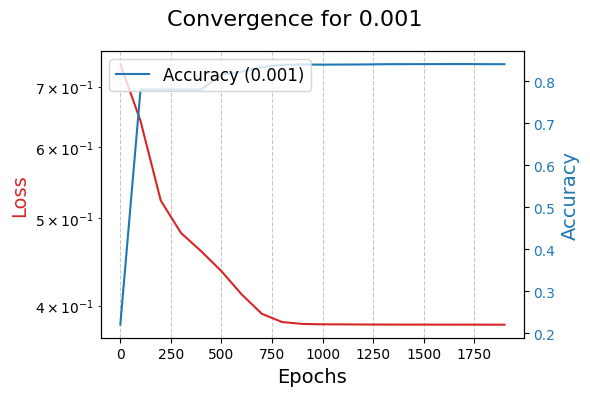

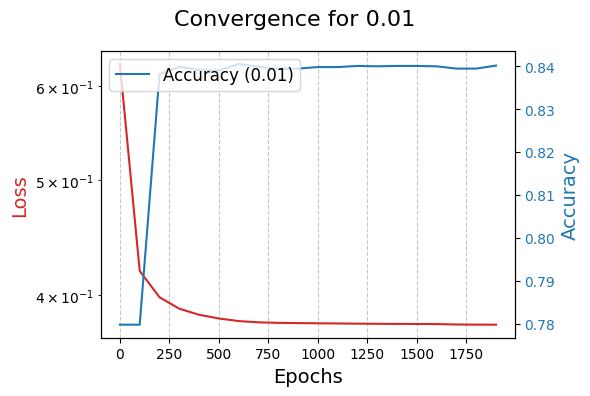

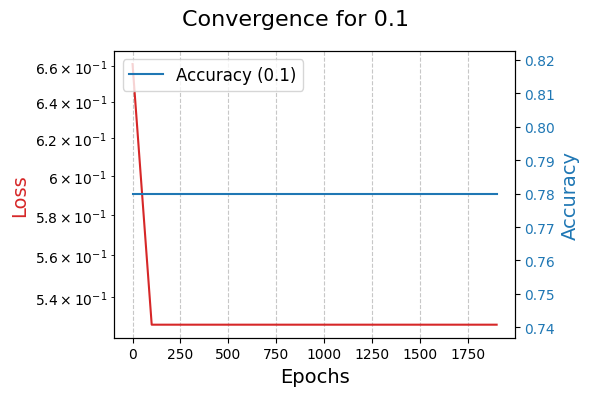

In [17]:
visualize_results(results)

In [18]:
optim_learning_rate = 0.01

### 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.

In [19]:
class Net(nn.Module):
    def __init__(self, n_features, architecture):
        super(Net, self).__init__()
        
        # Создание слоев на основе переданной архитектуры
        layers = []
        input_size = n_features
        for layer_size in architecture:
            layers.append(nn.Linear(input_size, layer_size))
            layers.append(nn.ReLU())  # Добавляем активацию ReLU после каждого слоя
            input_size = layer_size
        layers.append(nn.Linear(input_size, 1))  # Последний слой с одним выходом
        layers.append(nn.Sigmoid())  # Применяем сигмоид для бинарной классификации
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [20]:
architectures = [
    [8, 4],  # 1 скрытый слой с 8 нейронами и 2-й скрытый слой с 4 нейронами
    [16, 8, 4],  # 2 скрытых слоя с разным количеством нейронов
    [32, 16, 8, 4],  # 3 скрытых слоя
    [4],  # Один скрытый слой с 4 нейронами
    [8],  # Один скрытый слой с 8 нейронами
    [],  # Без скрытых слоев (просто линейная модель)
]

In [21]:
results = calc_loss(X_train, X_test, y_train, y_test, architectures=architectures, optim_lr=optim_learning_rate)

Testing architecture: [8, 4]
epoch 0
                        Test  set - loss: 0.5932198166847229, accuracy: 0.7797766923904419
                    
epoch 100
                        Test  set - loss: 0.40615740418434143, accuracy: 0.7797766923904419
                    
epoch 200
                        Test  set - loss: 0.3920729160308838, accuracy: 0.8392413854598999
                    
epoch 300
                        Test  set - loss: 0.3865576982498169, accuracy: 0.8397731184959412
                    
epoch 400
                        Test  set - loss: 0.38390713930130005, accuracy: 0.8401275873184204
                    
epoch 500
                        Test  set - loss: 0.38250917196273804, accuracy: 0.8395072817802429
                    
epoch 600
                        Test  set - loss: 0.38170093297958374, accuracy: 0.8395072817802429
                    
epoch 700
                        Test  set - loss: 0.3812030553817749, accuracy: 0.8388869166374207
              

<Figure size 600x400 with 0 Axes>

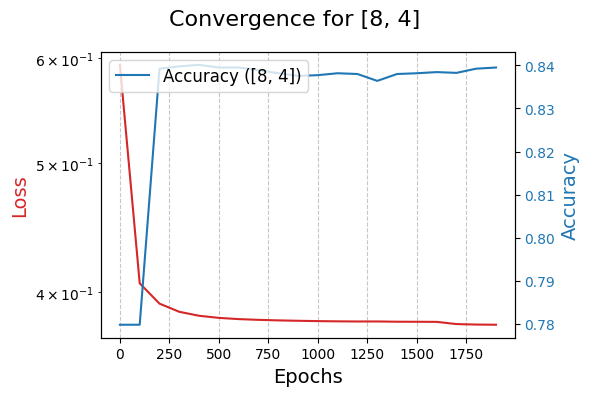

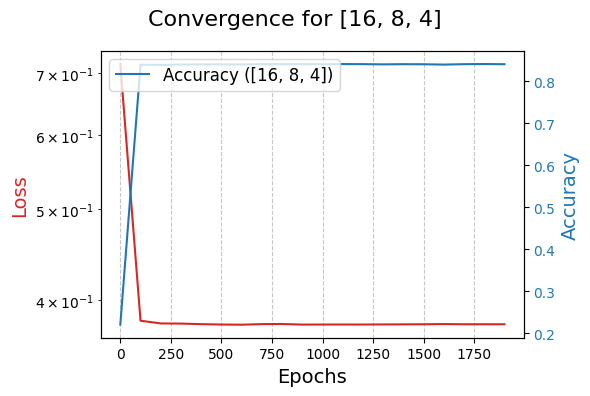

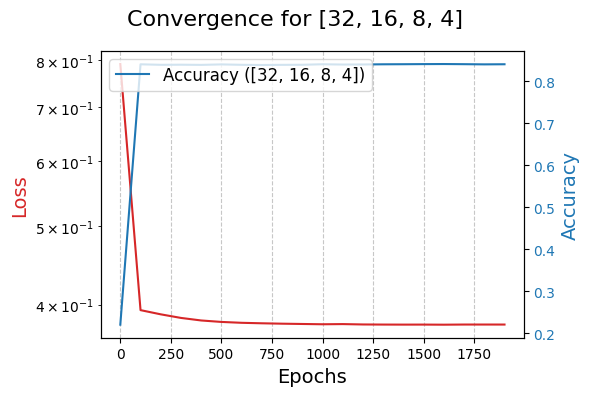

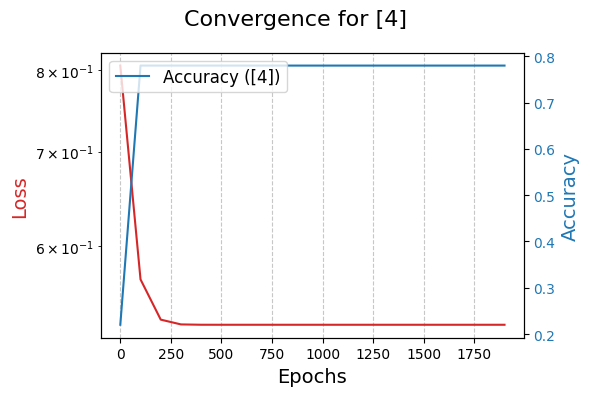

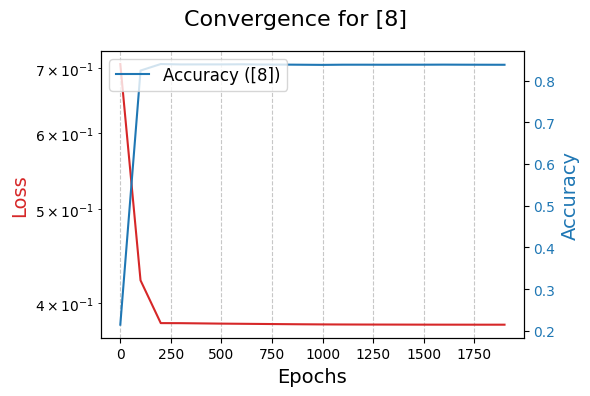

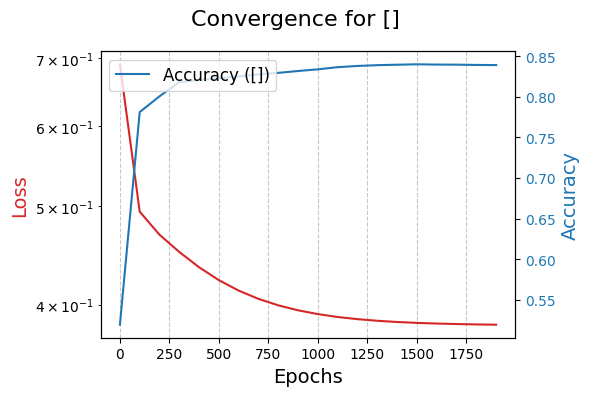

In [22]:
visualize_results(results)

### 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.

In [23]:
class Net(nn.Module):
    def __init__(self, n_features, activation_fn):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [24]:
activation_functions = [F.relu, torch.sigmoid, torch.tanh, F.leaky_relu]

In [25]:
results = calc_loss(X_train, X_test, y_train, y_test, activation_functions=activation_functions, optim_lr=optim_learning_rate)

Activation Function: relu
epoch 0
                        Test  set - loss: 0.6357911825180054, accuracy: 0.7797766923904419
                    
epoch 100
                        Test  set - loss: 0.4081500768661499, accuracy: 0.7797766923904419
                    
epoch 200
                        Test  set - loss: 0.3944486081600189, accuracy: 0.8387096524238586
                    
epoch 300
                        Test  set - loss: 0.38862890005111694, accuracy: 0.8392413854598999
                    
epoch 400
                        Test  set - loss: 0.38563627004623413, accuracy: 0.8392413854598999
                    
epoch 500
                        Test  set - loss: 0.3840283453464508, accuracy: 0.8401275873184204
                    
epoch 600
                        Test  set - loss: 0.3830830454826355, accuracy: 0.8402162194252014
                    
epoch 700
                        Test  set - loss: 0.3825201988220215, accuracy: 0.8401275873184204
                   

<Figure size 600x400 with 0 Axes>

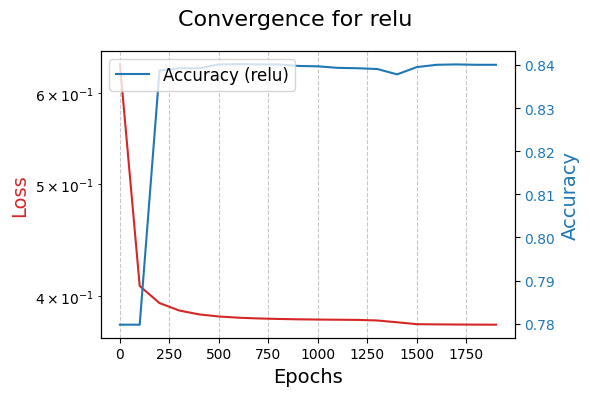

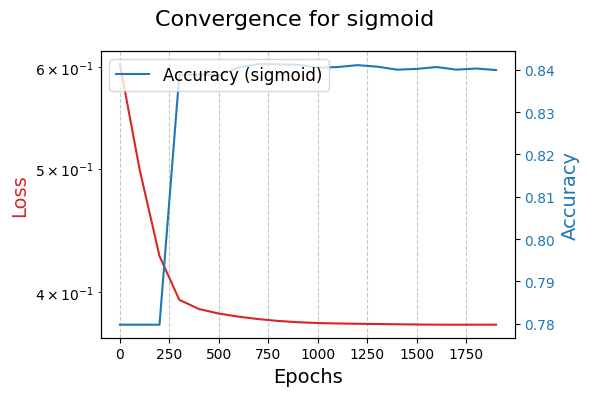

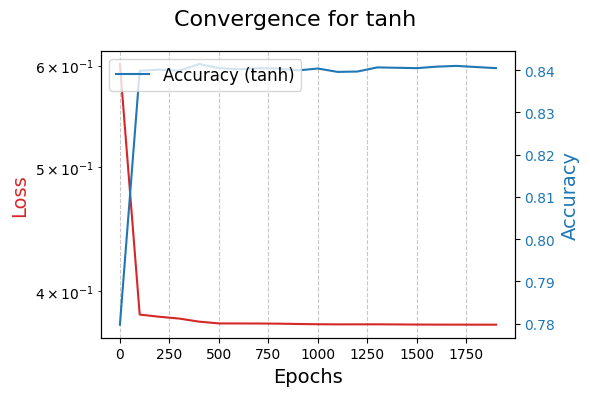

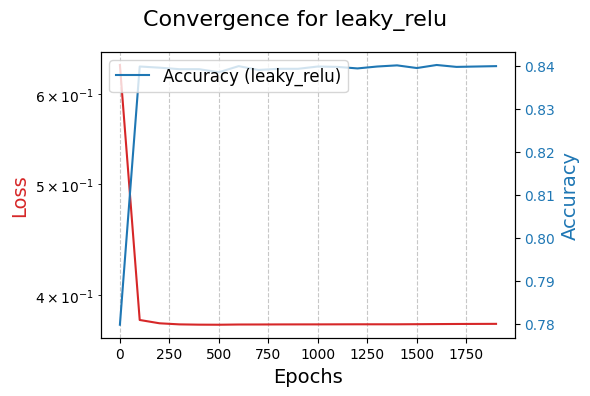

In [26]:
visualize_results(results)

In [27]:
optim_activation_function = F.leaky_relu

### 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.

In [28]:
optimizers = [
    ('SGD', optim.SGD),
    ('Adam', optim.Adam),
    ('RMSprop', optim.RMSprop),
    ('Adagrad', optim.Adagrad)
]

In [29]:
results = calc_loss(X_train, X_test, y_train, y_test, optimizers=optimizers, optim_lr=optim_learning_rate, optim_fn=optim_activation_function)

Optimizer: SGD
epoch 0
                        Test  set - loss: 0.6445154547691345, accuracy: 0.7797766923904419
                    
epoch 100
                        Test  set - loss: 0.5791001915931702, accuracy: 0.7797766923904419
                    
epoch 200
                        Test  set - loss: 0.5540127158164978, accuracy: 0.7797766923904419
                    
epoch 300
                        Test  set - loss: 0.5423164963722229, accuracy: 0.7797766923904419
                    
epoch 400
                        Test  set - loss: 0.5363951921463013, accuracy: 0.7797766923904419
                    
epoch 500
                        Test  set - loss: 0.5333109498023987, accuracy: 0.7797766923904419
                    
epoch 600
                        Test  set - loss: 0.5315540432929993, accuracy: 0.7797766923904419
                    
epoch 700
                        Test  set - loss: 0.5303996205329895, accuracy: 0.7797766923904419
                    
epoch 800
 

<Figure size 600x400 with 0 Axes>

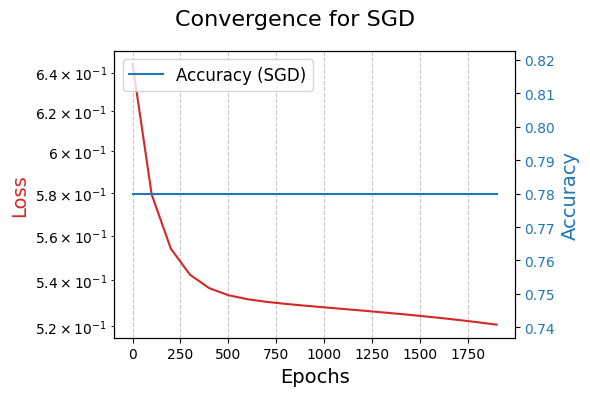

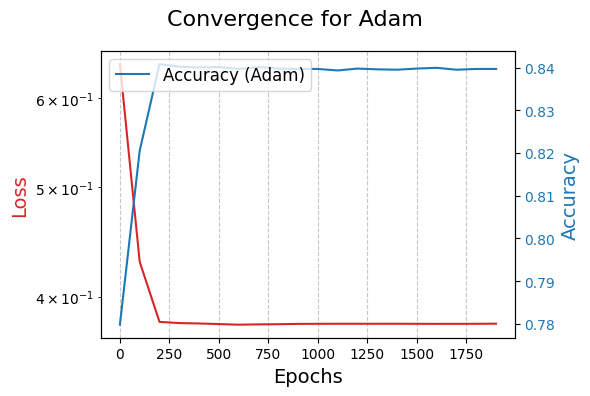

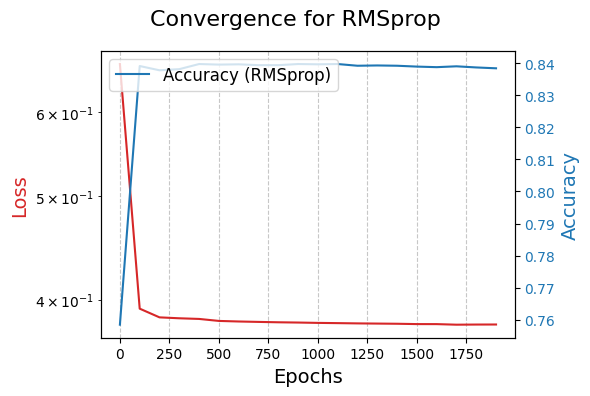

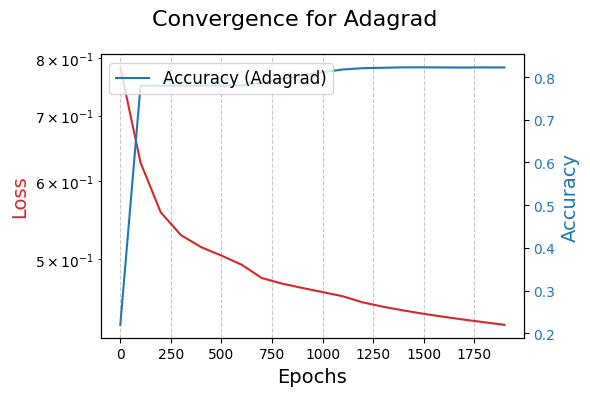

In [30]:
visualize_results(results)

### 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [31]:
init_types = ['random', 'xavier', 'he', 'zero']

In [32]:
results = calc_loss(X_train, X_test, y_train, y_test, init_types=init_types, optim_lr=optim_learning_rate, optim_fn=optim_activation_function)

Weight Initialization: random
epoch 0
                        Test  set - loss: 0.6903249025344849, accuracy: 0.7797766923904419
                    
epoch 100
                        Test  set - loss: 0.4445944130420685, accuracy: 0.8165544271469116
                    
epoch 200
                        Test  set - loss: 0.3788415491580963, accuracy: 0.8392413854598999
                    
epoch 300
                        Test  set - loss: 0.37812933325767517, accuracy: 0.8409252166748047
                    
epoch 400
                        Test  set - loss: 0.37778010964393616, accuracy: 0.8399503827095032
                    
epoch 500
                        Test  set - loss: 0.37785154581069946, accuracy: 0.8382665514945984
                    
epoch 600
                        Test  set - loss: 0.3779504895210266, accuracy: 0.8387982845306396
                    
epoch 700
                        Test  set - loss: 0.3780352771282196, accuracy: 0.8388869166374207
              

<Figure size 600x400 with 0 Axes>

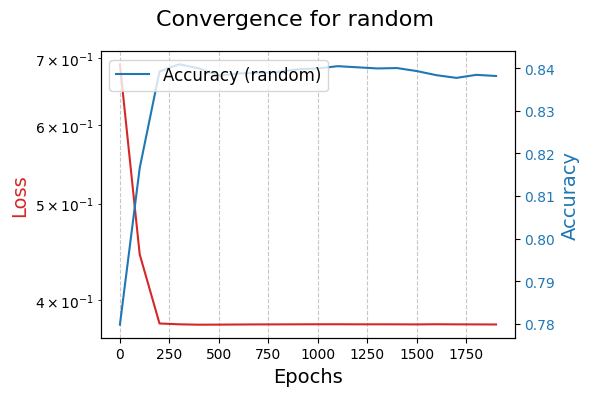

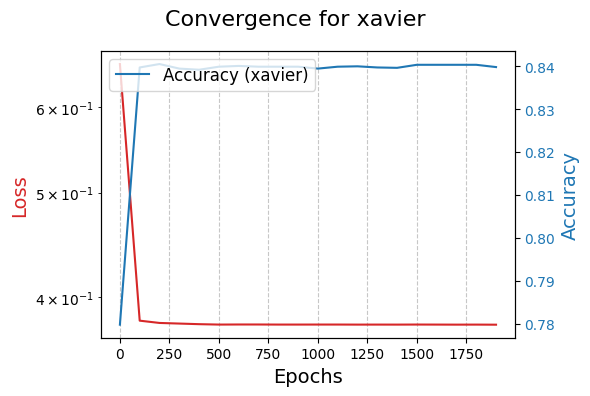

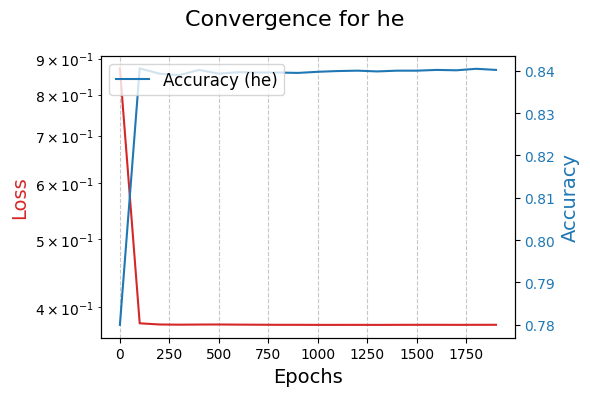

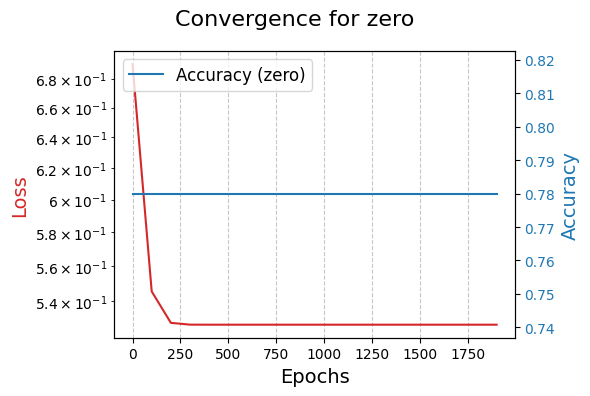

In [33]:
visualize_results(results)